# Taking Gradients of Patsy Spline Regressions

Given a vanilla multiple linear regression model of the form

$$ y \sim X \beta + \epsilon$$

where the columns of $X$ are constructed from b-splines, specifically with [Python's patsy library](https://patsy.readthedocs.io/en/latest/spline-regression.html), I need to be able to compute the gradient of $y$ with respect to the pre-spline-transformation x variables, $ \frac{dy}{dX} \Big|_x $, (not $\frac{dy}{d\beta}$).

Below is 1 dimensional regression to demonstrate with:

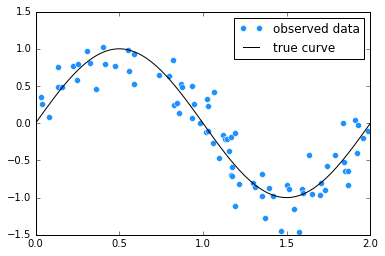

In [2]:
%matplotlib inline
import numpy as np
import patsy as pt
import pandas as pd

n = 80
x1 = np.sort(np.random.rand(n)*2)
f = lambda x: np.sin(2*np.pi*x*0.5)
y = f(x1) + 0.25 * np.random.randn(n)
plt.plot(x1, y, 'o', color="dodgerblue", mec="w", label="observed data")

x2 = np.linspace(0,2,100)
plt.plot(x2, f(x2), "k", label="true curve")
plt.legend();

Here is the b-spline regression using patsy, along with the first 5 rows of our spline transformed design matrix,

In [3]:
data = pd.DataFrame({"y": f(x1), "x": x1})
X = pt.dmatrix("bs(x, df=4, degree=3)", data, return_type="dataframe")
X.head(5)

,Intercept,"bs(x, df=4, degree=3)[0]","bs(x, df=4, degree=3)[1]","bs(x, df=4, degree=3)[2]","bs(x, df=4, degree=3)[3]"
0,1.0,0.000000,0.000000,0.000000e+00,0.0
1,1.0,0.024428,0.000115,1.802069e-07,0.0
2,1.0,0.124261,0.003254,2.821856e-05,0.0
3,1.0,0.238931,0.013607,2.546556e-04,0.0
4,1.0,0.244523,0.014348,2.765463e-04,0.0


along with a plot of the generated b-spline basis functions.

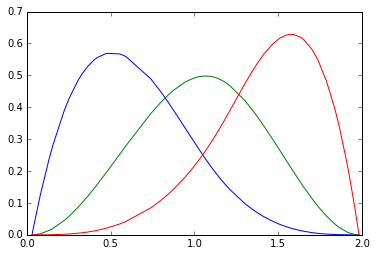

In [4]:
X = X.get_values()

plt.plot(x1, X[:,1]);
plt.plot(x1, X[:,2]);
plt.plot(x1, X[:,3]);

## Patsy's implementation of b-splines

Under the hood, patsy makes a call to [scipy.interpolate.splev](http://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.splev.html).  You can see this [here on line 59](https://github.com/pydata/patsy/blob/splines/patsy/splines.py).  Patsy is geared to parse regression formulas (```"y ~ bs(x, df=3 ... "```) that are interpreted from strings.  It looks to me like most of the code in this file is for preparing a call to ```splev```.  

In order to compute and then use the derivative of $y$ with respect to $x$ through the spline transformation in a straightforward in my code, I was able to modify Patsy's ```splines.py``` file to allow a user to include the order of the derivative as an additional parameter in the string formula.  You can see the modified file [here](https://gist.github.com/bwengals/694583587299eeb253dd4d05580f001b). 

To see the changes, pretty much just do a string search for "der" and see what comes up.  No other lines of code needed to be changed. 

#### Aside

One thing to note is that patsy's b-spline implementation doesn't handle extrapolation.  It raises exceptions if it is fed data outside of the interpolation range.  While this is reasonable behavior (extrapolating with splines sounds like risky business, to say the least), the ```splev``` function itself has an input flag specifying extrapolation behavior.  I might look into this more later.  It is possible a user may want it to return zero, or to go ahead and attempt extrapolation.

## Spline fit

I first load up my modified patsy, then plot the (un derivative'd) spline fit, then I use patsy to easily plot the derivative of the curve.

In [5]:
# add my custom patsy to the beginning of the python path
import sys
sys.path.insert(0, "/home/bill/packages/patsy/")

# do the fit and plots
import patsy as pt

# der = 0 means zeroth order derivative (no derivative taken). 
X = pt.dmatrix("bs(x, df=4, degree=3, der=0)", data, return_type="dataframe")

# solve for beta using least squares
beta, residuals, _, _ = np.linalg.lstsq(X, y)

# predict y across a dense x to plot the fitted curve.
#   Notice how the new x is made.  The min, max stuff is to prevent the 
#   patsy extrapolation exception I mentioned earlier
x_new = np.linspace(np.min(x1)+1e-4, np.max(x1)-1e-4, 200)
new_data = pd.DataFrame({"x": x_new})
X_new = pt.build_design_matrices([X.design_info], new_data)[0]

yhat = np.dot(X_new, beta)

plt.plot(x1, y, 'o', color="dodgerblue", mec="w", label="observed data")
plt.plot(x2, f(x2), "k", label="true curve")
plt.plot(x_new, yhat, "r", lw=2, label="fitted curve")
plt.legend();

TypeError: memorize_chunk() got an unexpected keyword argument 'der'

## Using Patsy to compute the derivative of the fit

The code below is the same as before, except notice the ```der``` argument is changed to equal 1.

In [6]:
# der = 0 means zeroth order derivative (no derivative taken). 
X_der = pt.dmatrix("bs(x, df=4, degree=3, der=1)", data, return_type="dataframe")
# keep upping der for 2nd, 3rd, etc order derivatives, until splev gives out. 

X_der_new = pt.build_design_matrices([X_der.design_info], new_data)[0]

yhat_der = np.dot(X_der_new, beta)

plt.plot(x_new, yhat, "r", lw=2, label="fitted curve")
plt.plot(x_new, yhat_der, "b", lw=2, label="1st derivative")
plt.plot(x1, y, 'o', color="dodgerblue", mec="w", label="observed data")
plt.legend();

TypeError: memorize_chunk() got an unexpected keyword argument 'der'

#  Autograd

[Autograd](https://github.com/HIPS/autograd)

Since I was using Autograd for what I was trying to do, I tried to get autograd to be able to take this derivative, **without making a new call to patsy's bs** with the ```der``` argument.  

Unfortunately, Autograd doesn't currently know about ```scipy.interpolate.splev```.  Below is my crack at wrapping it.  While very simple, it doesn't work, and I need to look further into why.  This could probably be done without modifying Autograd's source, but there would be no reason not to add it (if it worked). 

In [7]:
# start of script called 'interpolate.py', put into /autograd/autograd/scipy/

from __future__ import division
import scipy.interpolate

import autograd.numpy as anp 
from autograd.numpy.numpy_wrapper import wrap_namespace

wrap_namespace(scipy.interpolate.__dict__, globals())  # populates module namespace

def make_grad_splev(ans, x, tck, **kwargs):
    if "der" in kwargs:
        der = kwargs.pop("der") + 1
    else:
        der = 1 
    def gradient_product(g):
        return g * splev(x, tck, der, **kwargs)
    return gradient_product
splev.defgrad(make_grad_splev)

# end of script

### Notes

- ```tck``` is a required arguement of ```splev```
- ```der``` and the extrapolation flag are not, that's why they are in **kwargs

